In [1]:
import numpy as np
import xarray as xr
import os
import glob
import numpy.ma as ma

[xmin, xmax, ymin, ymax] = [334, 350, 10, 30]
[tmin, tmax] = ["1993", "2022"]

# mean sst
file_path = os.path.expandvars('$WORK/data/OISST/monthly/sst.mon.mean.nc')
ds = xr.open_dataset(file_path)
sst = ds['sst'].sel(lon=slice(xmin, xmax), lat=slice(ymin, ymax), time=slice(tmin, tmax))
lon = ds['lon'].sel(lon=slice(xmin, xmax)).values
lat = ds['lat'].sel(lat=slice(ymin, ymax)).values
sstm = np.mean(sst.values, axis=0)

# mean chl
file_path = os.path.expandvars('$WORK/data/GlobColour/monthly/cmems_obs-oc_glo_bgc-plankton_my_l4-multi-4km_P1M_CHL_1997-09-01-2024-08-01.nc')
ds = xr.open_dataset(file_path)
ds['longitude'] = (ds['longitude'] + 360) % 360
ds=ds.sortby('longitude')
chlm = np.nanmean(ds['CHL'].sel(longitude=slice(xmin, xmax), latitude=slice(ymin, ymax), time=slice(tmin, tmax)).values, axis=0)
lonc = ds['longitude'].sel(longitude=slice(xmin, xmax)).values
latc = ds['latitude'].sel(latitude=slice(ymin, ymax)).values

# mean wind speed
data_dir = os.path.expandvars('$WORK/data/CCMP/monthly/')
file_pattern = os.path.join(data_dir, 'CCMP_Wind_Analysis_??????_monthly_mean_V03.1_L4.nc')
file_list = sorted(glob.glob(file_pattern))
ds = xr.open_mfdataset(file_list, combine='by_coords')
um=np.mean(ds['u'].sel(longitude=slice(xmin,xmax), latitude=slice(ymin,ymax),time=slice(tmin,tmax)).values, axis=0)
vm=np.mean(ds['v'].sel(longitude=slice(xmin,xmax), latitude=slice(ymin,ymax),time=slice(tmin,tmax)).values, axis=0)
lonw = ds['longitude'].sel(longitude=slice(xmin, xmax)).values
latw = ds['latitude'].sel(latitude=slice(ymin, ymax)).values
LON, LAT = np.meshgrid(lonw, latw)
um_masked = ma.masked_where(np.isnan(sstm), um)
vm_masked = ma.masked_where(np.isnan(sstm), vm)

/tmp/ipykernel_213066/1027394072.py:23: RuntimeWarning: Mean of empty slice
  chlm = np.nanmean(ds['CHL'].sel(longitude=slice(xmin, xmax), latitude=slice(ymin, ymax), time=slice(tmin, tmax)).values, axis=0)


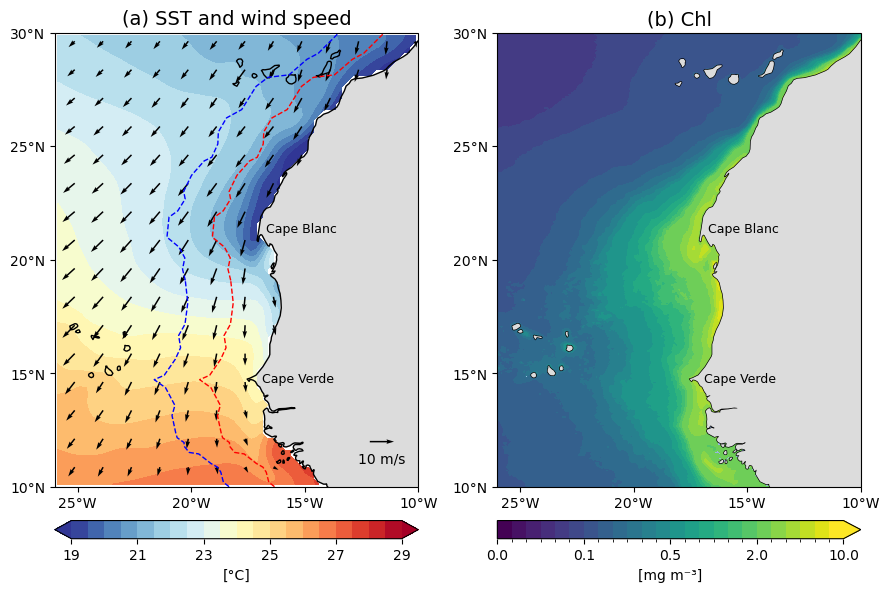

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader, natural_earth
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from shapely.geometry import LineString
import matplotlib.colors as mcolors


fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(9, 7),
    subplot_kw={'projection': ccrs.PlateCarree()}
)

contour1 = ax1.contourf(
    lon, lat, sstm, levels=np.linspace(19, 29, 21),
    cmap='RdYlBu_r', extend='both', vmin=19, vmax=29
)
step=5
qv = ax1.quiver(LON[3::step, 3::step], LAT[3::step, 3::step], um_masked[3::step, 3::step], vm_masked[3::step, 3::step], scale=150, color='k')
ax1.quiverkey(qv, X=0.9, Y=0.1, U=10,
             label='10 m/s', labelpos='S',
             coordinates='axes')
ax1.coastlines()
ax1.add_feature(cfeature.LAND, facecolor="gainsboro")
ax1.xaxis.set_major_formatter(LongitudeFormatter(dms=False, number_format='.0f'))
ax1.yaxis.set_major_formatter(LatitudeFormatter(dms=False, number_format='.0f'))
ax1.set_xticks(range(-25, -5, 5), crs=ccrs.PlateCarree())
ax1.set_yticks(range(10, 36, 5), crs=ccrs.PlateCarree())
ax1.set_title('(a) SST and wind speed', fontsize=14)

shapefile_path = natural_earth(category='physical', name='coastline', resolution='110m')
reader = Reader(shapefile_path)
for record in reader.records():
    geometry = record.geometry
    if isinstance(geometry, LineString) and geometry.length > 10.0:
        coords = [
            (x, y) for x, y in geometry.coords
            if xmin-360 <= x <= xmax-360+1 and ymin <= y <= ymax+1
        ]
        if coords:
            lons, lats = zip(*coords)
            ax1.plot([lon - 2 for lon in lons], lats, transform=ccrs.PlateCarree(),
                     color='red', linestyle='--', linewidth=1)
            ax1.plot([lon - 4 for lon in lons], lats, transform=ccrs.PlateCarree(),
                     color='blue', linestyle='--', linewidth=1)

ax1.set_extent([xmin-360, xmax-360, ymin, ymax], crs=ccrs.PlateCarree())
cbar = plt.colorbar(contour1, ax=ax1, orientation='horizontal', pad=0.05, label='[°C]')
cbar.set_ticks(np.linspace(19, 29, 6))

ticks = [0, 0.1, 0.5, 2.0, 10]
subdivisions_per_interval = 5  

levels = []
for i in range(len(ticks) - 1):
    seg = np.linspace(ticks[i], ticks[i+1], subdivisions_per_interval + 1, endpoint=False)
    levels.extend(seg.tolist())
levels.append(ticks[-1])  
levels = np.array(levels)
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=256)

ax2.add_feature(cfeature.OCEAN, zorder=0)
contour2 = ax2.contourf(lonc, latc, chlm,
    levels=levels, norm=norm, cmap='viridis', extend='max',
    transform=ccrs.PlateCarree(),  # make sure to specify the transform
    zorder=1
)

ax2.coastlines()
ax2.add_feature(cfeature.LAND, facecolor="gainsboro", zorder = 2)
ax2.set_title('(b) Chl', fontsize=14)
ax2.xaxis.set_major_formatter(LongitudeFormatter(dms=False, number_format='.0f'))
ax2.yaxis.set_major_formatter(LatitudeFormatter(dms=False, number_format='.0f'))
ax2.set_xticks(range(-25, -5, 5), crs=ccrs.PlateCarree())
ax2.set_yticks(range(10, 36, 5), crs=ccrs.PlateCarree())
ax2.set_extent([xmin-360, xmax-360, ymin, ymax], crs=ccrs.PlateCarree())

cbar = plt.colorbar(
    contour2, ax=ax2,
    ticks=ticks,
    orientation='horizontal',
    pad=0.05,
    label='[mg m⁻³]'
)

for ax in (ax1, ax2):
    ax.text(0.58, 0.56, 'Cape Blanc', transform=ax.transAxes, fontsize=9, color='k')
    ax.text(0.57, 0.23, 'Cape Verde', transform=ax.transAxes, fontsize=9, color='k')

plt.tight_layout()
plt.show()
